# 1 Data Collection & Cleaning

## 1.2 Residential Property Sales

## 1.2.1 Residential Property Sales - Data Cleaning (Step 1)

This notebook reads in the Residential Property Sales csv file type and cleans the data, outputting to csv the cleaned data.
Mean sales values for residential property sales are calculated and published each quarter with columns denoting each quarter.
Data is available from https://www.ons.gov.uk/peoplepopulationandcommunity/housing/bulletins/housepricestatisticsforsmallareas/yearendingmarch2020/relateddata?sortBy=title&query=LSOA and licensed under Open Government Licence v3.0 (Crown Copyright 2020).

Libraries used include:
1. numpy - (scientific numerical package for Python that enables working with arrays)
2. pandas - (data analysis library)
3. matplotlib - (enables plotting and visualisation in Python)
4. openpyxl / load_workbook (opens Excel xlsx files)

In [1]:
#Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from openpyxl import load_workbook

The function 'setup_df_saleprices' takes the Excel xlsx workbook as input (filepath) and undertakes the following steps returning a new dataframe titled df.
1. Drops unwanted columns for years which there is only partial data - following review of the metadata.
2. Null entries are denoted as ':' which is not recognised as null by pandas and prevents numerical calculation - all ':' existences are replaced with zero.
3. Two lists are created of 'years to keep' and 'years to remove' based on availability of annual electricity consumption data.
4. Unwanted years are dropped.
5. Data types are changed to float / numerical, the mean for the given year is calculated and allocated to a new column titled 'Year'.
6. Once (5) completed for all years, quarterly column entries are removed from the data frame.


In [3]:
def setup_df_saleprices(filepath):       
    
    #Read Residential Property Sales raw data set
    df = pd.read_excel(filepath, header=5, sheet_name='Data')
    
    #Drop unwanted columns at edge of data set
    df = df.dropna(axis=1)
    df = df.drop("Year ending Dec 1995", axis=1)
    df = df.drop("Year ending Mar 2020", axis=1)
    
    #Replace all N/A documented as ":" with 0 to allow change of dtype and calculation of mean
    df = df.replace(':', 0)
    
    #List of years to keep and remove to iterate over
    Years_keep = list(range(2010, 2020))
    Years_remove = list(range(1996, 2010))
    
    #Remove columns of unwanted years
    for year in Years_remove:
        df = df.drop("Year ending Mar " +str(year), axis=1)
        df = df.drop("Year ending Jun " +str(year), axis=1)
        df = df.drop("Year ending Sep " +str(year), axis=1)
        df = df.drop("Year ending Dec " +str(year), axis=1)
    
    #Change dtype to numeric / float, set-up new column for year and calculate mean sales price for that year
        #Converts dtype within for loop so only running on selected year columns each time
    for year in Years_keep:
        
        df[["Year ending Mar " + str(year), "Year ending Jun " + str(year), "Year ending Sep " + str(year), "Year ending Dec " + str(year)]] = df[["Year ending Mar " + str(year), "Year ending Jun " + str(year), "Year ending Sep " + str(year), "Year ending Dec " + str(year)]].apply(pd.to_numeric)
                       
        df[year] = df[["Year ending Mar " + str(year), "Year ending Jun " + str(year), "Year ending Sep " + str(year), "Year ending Dec " + str(year)]].mean(axis=1)
    
    #Once new columns of mean price per year are added to df above, remove the original quarterly year columns
    for year in Years_keep:
        df = df.drop("Year ending Mar " +str(year), axis=1)
        df = df.drop("Year ending Jun " +str(year), axis=1)
        df = df.drop("Year ending Sep " +str(year), axis=1)
        df = df.drop("Year ending Dec " +str(year), axis=1)                   
    
    return df 
    

Runs the function 'setup_df_saleprices' on the Mean price paid for residential properties by LSOA - downloaded (XX/09/2020).

In [4]:
df_meansaleprice = setup_df_saleprices("HPSSA Dataset 47 - Mean price paid for residential properties by LSOA.xls")

Saves the data frame to the folder '1_DataCleaning' as a csv.

In [5]:
df_meansaleprice.to_csv('1_DataCleaning/meansaleprice_year.csv')

In [6]:
df_meansaleprice.head()

,Local authority code,Local authority name,LSOA code,LSOA name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,E06000001,Hartlepool,E01011949,Hartlepool 009A,89911.739883,87035.297368,104939.840812,86159.861111,72323.511905,83883.680556,88157.692307,106750.974027,84179.071174,82437.203947
1,E06000001,Hartlepool,E01011950,Hartlepool 008A,59053.601191,57295.037072,42647.755204,55772.976913,46544.292148,37951.326473,38188.108441,45259.666128,38350.647823,41548.587795
2,E06000001,Hartlepool,E01011951,Hartlepool 007A,62041.975864,65946.227106,77627.442130,65114.744695,65891.638218,55681.250000,78781.761756,59629.383089,56303.215368,61800.313962
3,E06000001,Hartlepool,E01011952,Hartlepool 002A,77643.959524,47782.416667,33552.500000,82506.824010,72020.066964,62777.614583,74723.325893,77829.545454,64287.797619,70343.923611
4,E06000001,Hartlepool,E01011953,Hartlepool 002B,57235.371429,55091.644886,27189.285714,13925.000000,59914.880952,64302.321428,85407.944139,79333.690476,61388.392857,60436.033333


## 1.2.2 Residential Property Sales - Data Cleaning (Step 2)

So far the original Residential Property Sales data has been cleaned to provide annualized data for each LSOA. This has been output with data for each year provided in a separate column. In order to combine with the LSOA Energy Consumption data this needs to be shaped so that there is a single column denoting the year the data for each feature vector / row corresponds to. 

The function 'setup_df_saleprices_year_as_column' transforms the data so that each feature vector / row includes residential sales price data for a specific year, with the year noted in a new column 'Year'.

In [7]:
def setup_df_saleprices_year_as_column(dataframe): 
    
    #List of years to keep to iterate over
    Years_keep = list(range(2010, 2020))
    
    #Create new column "Year" and pivot array      
    #Define empty notebook df_combined 
    df_combined = None
        
    for year in Years_keep:
        df_eachyear = dataframe[['Local authority code', 'Local authority name', 'LSOA code', 'LSOA name', year]]
        df_eachyear["Year"] = year
        df_eachyear = df_eachyear.rename(columns={year:'Mean_price_paid'})
        
        #Add each df year to master df
        if df_combined is None:
            df_combined = df_eachyear
        else:
            df_combined = pd.concat([df_combined, df_eachyear], axis=0)                   
    
    return df_combined 

Runs the function 'setup_df_saleprices_year_as_column' on the previously defined data frame: df_meansaleprice.

In [8]:
df_meansaleprice_column = setup_df_saleprices_year_as_column(df_meansaleprice)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Saves the data frame to the folder '1_DataCleaning' as a csv.

In [9]:
df_meansaleprice_column.to_csv('1_DataCleaning/meansaleprice.csv')

The following pandas dataframe functions are run to visually check that the data frame is as expected:

.head() - displays the top entries
.tail() - displays the last entries
.info() - provides the number of entries / feature vectors, null objects and data types for each feature variable / column.
.describe() - provides a statistical overview
.idmax - displays the maximum value and feature vector for the requested column and is a useful manual check on potential outliers, enabling further removal/cleaning if required.

In [10]:
df_meansaleprice_column.head()

,Local authority code,Local authority name,LSOA code,LSOA name,Mean_price_paid,Year
0,E06000001,Hartlepool,E01011949,Hartlepool 009A,89911.739883,2010
1,E06000001,Hartlepool,E01011950,Hartlepool 008A,59053.601191,2010
2,E06000001,Hartlepool,E01011951,Hartlepool 007A,62041.975864,2010
3,E06000001,Hartlepool,E01011952,Hartlepool 002A,77643.959524,2010
4,E06000001,Hartlepool,E01011953,Hartlepool 002B,57235.371429,2010


In [11]:
df_meansaleprice_column.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347530 entries, 0 to 34752
Data columns (total 6 columns):
Local authority code    347530 non-null object
Local authority name    347530 non-null object
LSOA code               347530 non-null object
LSOA name               347530 non-null object
Mean_price_paid         347530 non-null float64
Year                    347530 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 18.6+ MB


## 1.2.3 Residential Property Sales Graphical Plots

Scatter plot of mean residential property sales price against year, showing the variance and any overall trend across the full data set. It can be seen from the below plot that the variance across LSOA's in the UK is significant, but there is a trend of increasing house prices per year.

In [34]:
plt.rcParams['figure.figsize'] = [16, 10]

In [35]:
plt.style.use('seaborn-darkgrid')

In [36]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('axes', labelsize=20) 
matplotlib.rc('axes', titlesize=20) 

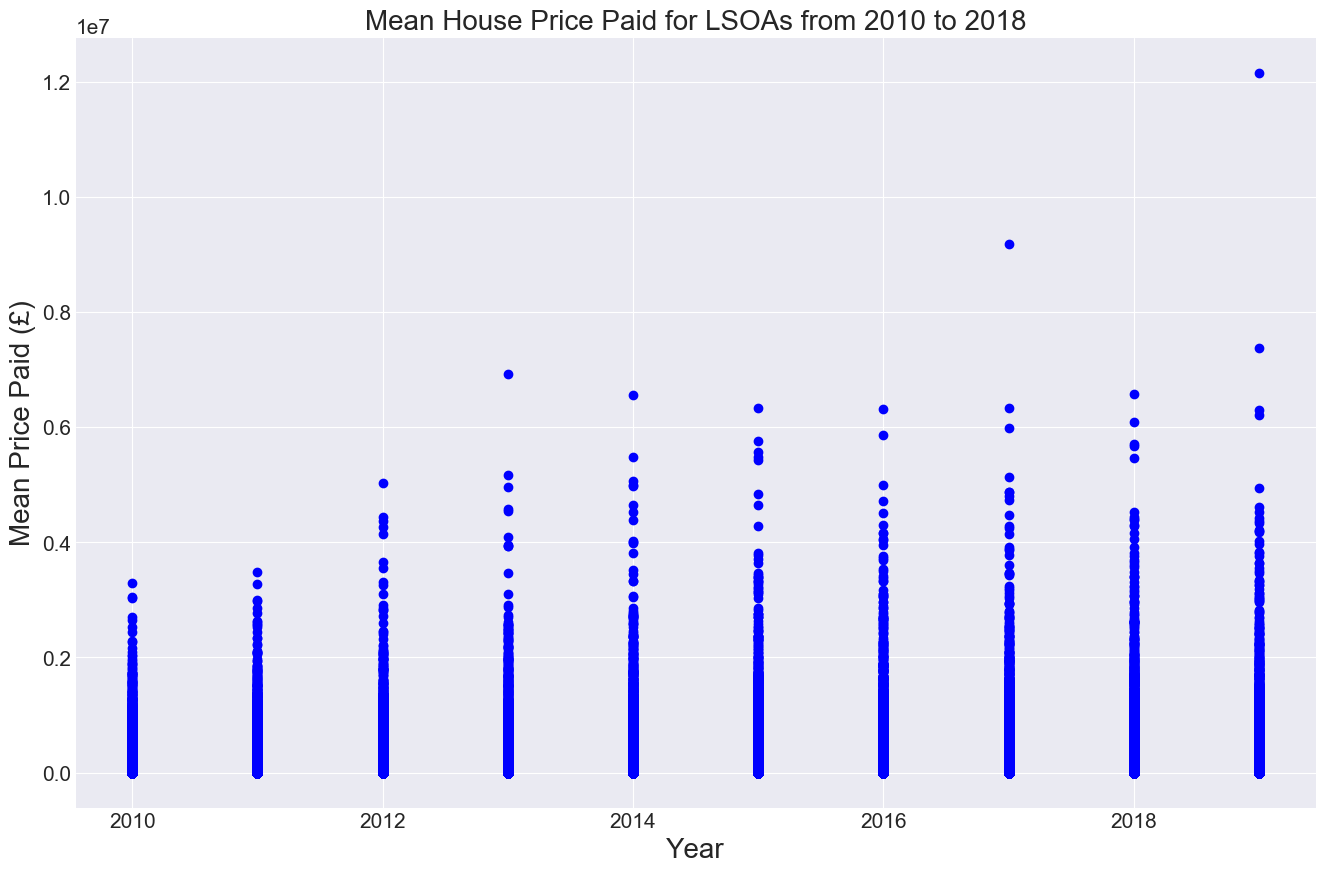

In [37]:
plt.scatter(df_meansaleprice_column.Year, df_meansaleprice_column.Mean_price_paid, color='blue')
plt.xlabel("Year")
plt.ylabel("Mean Price Paid (£)")
plt.title("Mean House Price Paid for LSOAs from 2010 to 2018")
plt.show()

Histogram of mean price paid shows a strong positive skew and a long tail, which is consistent with the expectation that there will be a core range of house prices with fewer larger value properties. These higher priced properties would be expected to be larger properties in wealthier locations (and are expected to correlate well with higher energy consumption).

The first plot displays data for properties up to £2million whilst the second plot shows properties up to £1million.

In [26]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('axes', labelsize=30) 
matplotlib.rc('axes', titlesize=30) 

Mean is 248789.4890766243
Standard deviation is 215872.84297178703


Text(0.5,1,'Histogram of Mean Price Paid 2010 to 2018 (20bins, £2m cap)')

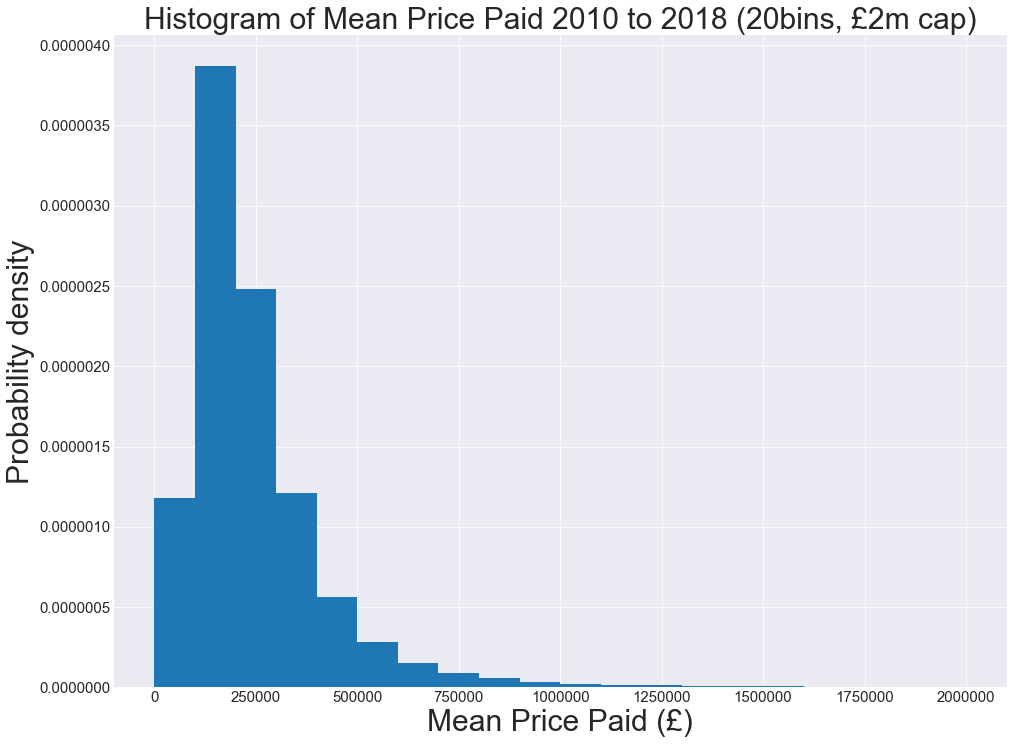

In [29]:
fig, ax = plt.subplots()

nu_bins = 20

plt.hist(df_meansaleprice_column.Mean_price_paid, bins=nu_bins, range=(0,2000000), density=True)

mu = (df_meansaleprice_column.Mean_price_paid).mean()  # mean of distribution
sigma = (df_meansaleprice_column.Mean_price_paid).std()  # standard deviation of distribution

print("Mean is " +str(mu))
print("Standard deviation is " +str(sigma))

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (nu_bins - mu))**2))
ax.plot(nu_bins, y, '--', color='green')
ax.set_xlabel('Mean Price Paid (£)')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of Mean Price Paid 2010 to 2018 (20bins, £2m cap)')

Mean is 248789.4890766243
Standard deviation is 215872.84297178703


Text(0.5,1,'Histogram of Mean Price Paid 2010 to 2018 (20 bins, £1m cap)')

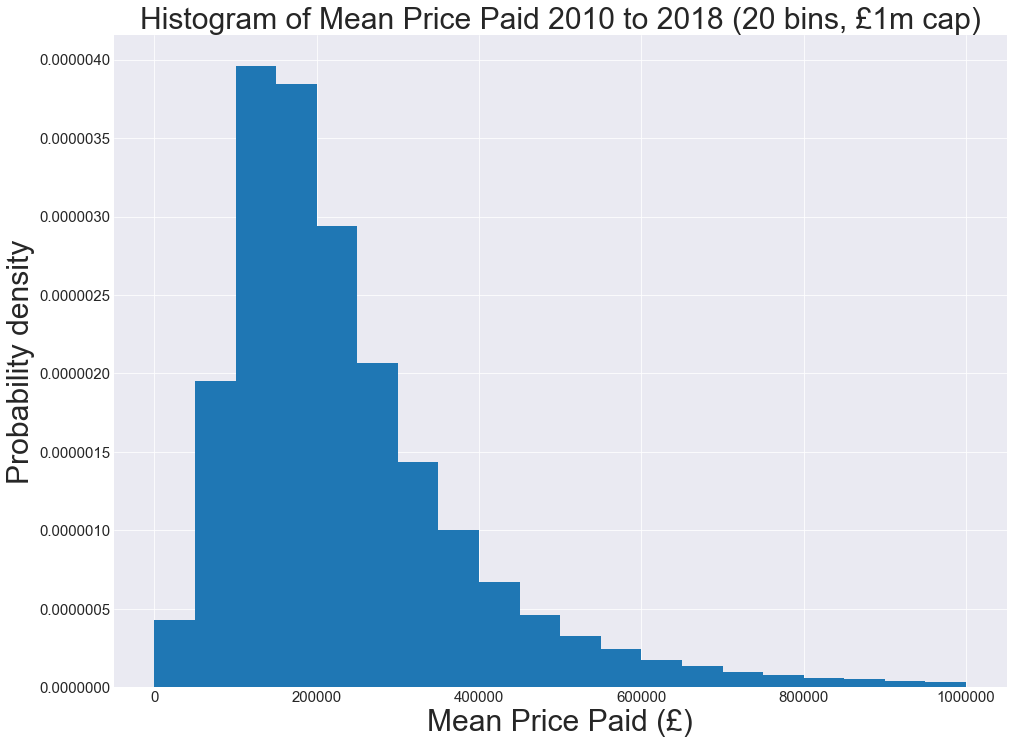

In [30]:
fig, ax = plt.subplots()

nu_bins = 20

plt.hist(df_meansaleprice_column.Mean_price_paid, bins=nu_bins, range=(0,1000000), density=True)

mu = (df_meansaleprice_column.Mean_price_paid).mean()  # mean of distribution
sigma = (df_meansaleprice_column.Mean_price_paid).std()  # standard deviation of distribution

print("Mean is " +str(mu))
print("Standard deviation is " +str(sigma))

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (nu_bins - mu))**2))
ax.plot(nu_bins, y, '--', color='green')
ax.set_xlabel('Mean Price Paid (£)')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of Mean Price Paid 2010 to 2018 (20 bins, £1m cap)')

The same understanding can similarly be read and is backed up by the box-plot diagram below.

{'whiskers': [<matplotlib.lines.Line2D at 0x24ead4cef98>,
 'caps': [<matplotlib.lines.Line2D at 0x24eb0ac2898>,
 'boxes': [<matplotlib.lines.Line2D at 0x24ead4cee48>],
 'medians': [<matplotlib.lines.Line2D at 0x24eb0acf128>],
 'fliers': [<matplotlib.lines.Line2D at 0x24eb0acf550>],
 'means': []}

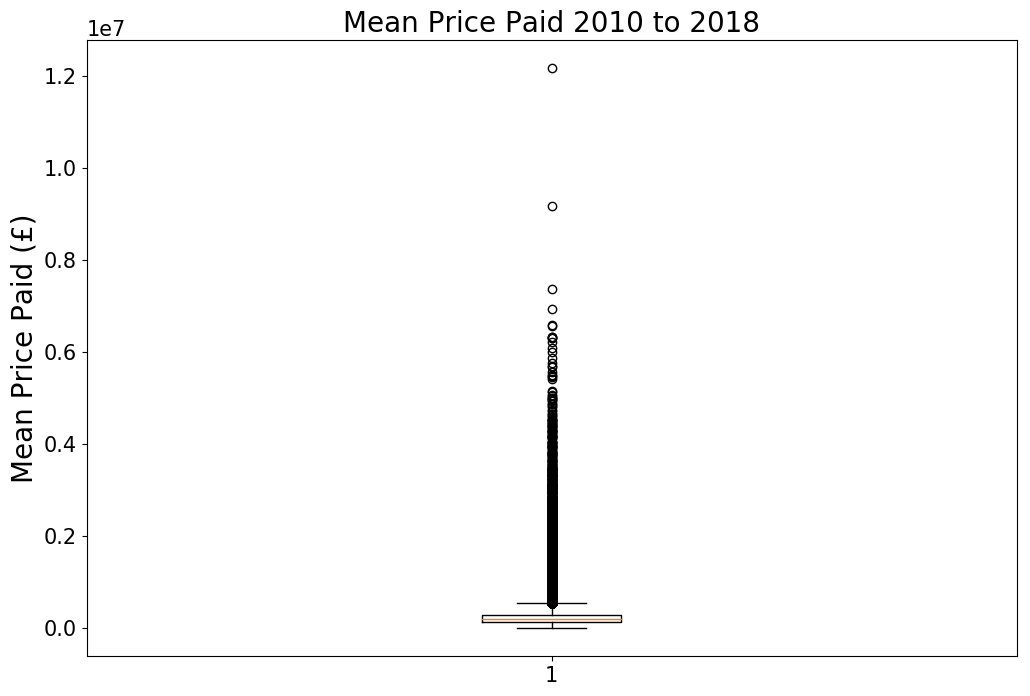

In [32]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('axes', labelsize=20) 
matplotlib.rc('axes', titlesize=20) 

fig1, ax1 = plt.subplots()
ax1.set_title('Mean Price Paid 2010 to 2018')
ax1.set_ylabel('Mean Price Paid (£)')
ax1.boxplot(df_meansaleprice_column.Mean_price_paid)

Text(0,0.5,'Mean Price Paid (£)')

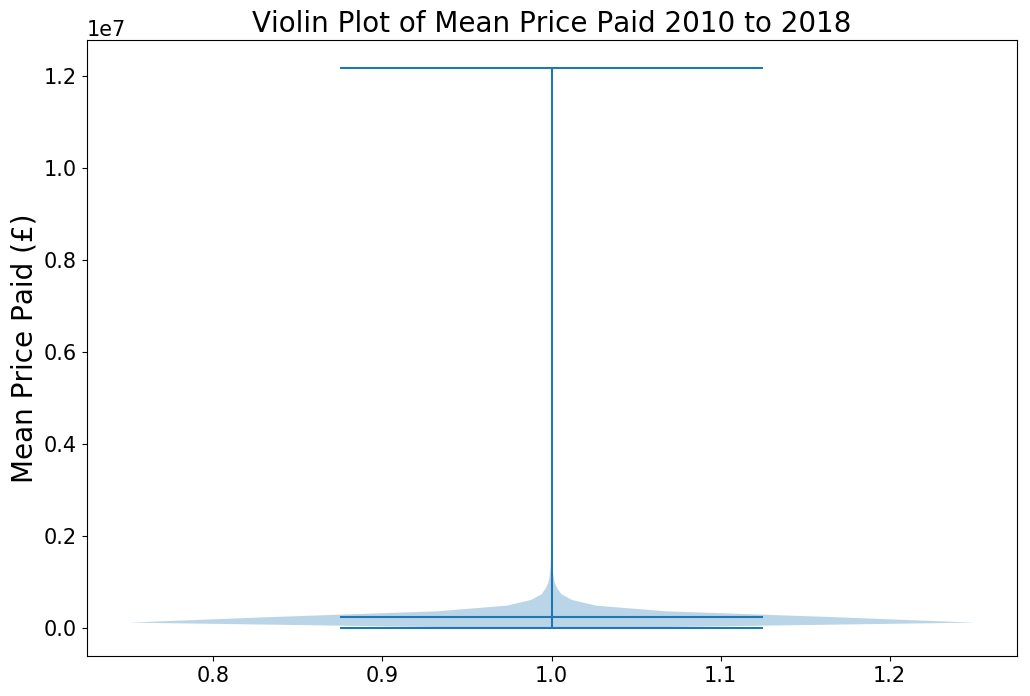

In [33]:
# plot violin plot
fig1, ax1 = plt.subplots()
ax1.violinplot(df_meansaleprice_column.Mean_price_paid,
                  showmeans=True,
                  showmedians=False)
ax1.set_title('Violin Plot of Mean Price Paid 2010 to 2018')
ax1.set_ylabel('Mean Price Paid (£)')